In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
%matplotlib inline

In [2]:
from skimage.feature import hog
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [48]:
import os
def test_hog_features(img_dirs, img_names):
    fig = plt.figure(figsize=(8, 8))
    rows = len(img_dirs)
    cols = len(img_dirs)
    for idx in range(len(img_dirs)):
        plt.subplot(rows, cols, 2*idx + 1)
        img = mpimg.imread(os.path.join(img_dirs[idx], img_names[idx]))
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        plt.imshow(gray, cmap='gray')
    
        plt.subplot(rows, cols, 2*idx + 2)
        features, hog_img = get_hog_features(gray, orient=9, pix_per_cell=8, cell_per_block=2, vis=True)
        plt.imshow(hog_img, cmap='gray')
    plt.tight_layout()
    #plt.savefig('car_nocar_hogfeatuer.jpg')

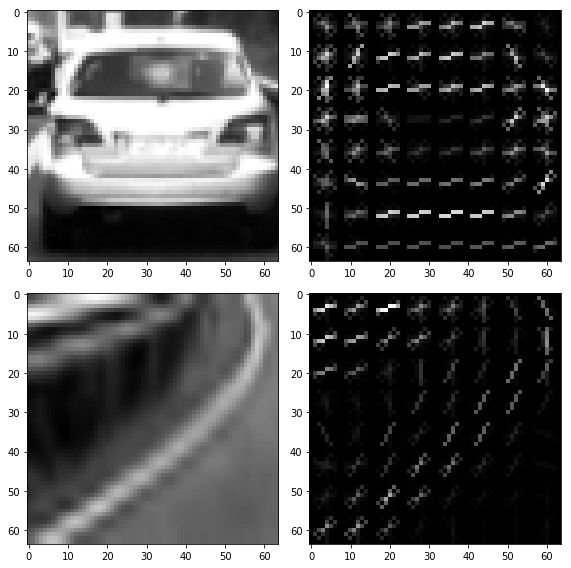

In [49]:
test_hog_features(['./vehicles/KITTI_extracted', './non-vehicles/GTI'], ['31.png', 'image187.png'])

In [5]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

In [6]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [7]:
def extract_img_features(img_name, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256),
                     hog_channel=0, orient=9, pix_per_cell=8, cell_per_block=2):
    img = cv2.imread(img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = img.astype(np.float32)  # png file has value between 0 and 1
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(img)
        
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    
    if hog_channel == -1:
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel],
                                                 orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel],
                                        orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    features = np.concatenate([spatial_features, hist_features, hog_features])
    return features

In [8]:
def extract_features(img_list, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256),
                     hog_channel=0, orient=9, pix_per_cell=8, cell_per_block=2):
    features_ary = []
    for img_name in img_list:
        features = extract_img_features(img_name, cspace, spatial_size, hist_bins, hist_range,
                                       hog_channel, orient, pix_per_cell, cell_per_block)
        features_ary.append(features)
    return features_ary

In [9]:
import glob
def read_data(data_dir):
    data = []
    for dir, _ ,_ in os.walk(data_dir):
        data.extend(glob.glob(os.path.join(dir,'*.*')))
    return data

In [10]:
car_list = read_data('./vehicles')
nocar_list = read_data('./non-vehicles')
print(len(car_list), len(nocar_list))

8792 8968


In [16]:
channel_parameters = ['YCrCb', 'YUV', 'HLS', 'LUV', 'HSV', 'RGB']

In [12]:
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score

class Model():
    def __init__(self, features_parameter):
        self.cspace = features_parameter[0]
        self.hog_channel = features_parameter[1]
        self.clf = LinearSVC(C=1, random_state=0)
        self.scaler = StandardScaler()
        self.spatial_size = (16, 16)
        self.hist_bins = 16
        self.hist_range = (0, 256)
        self.orient = 9
        self.pix_per_cell = 8
        self.cell_per_block = 2
        self.beta = 0.5
    
    def scale_features(self, car_list, nocar_list):
        car_features = extract_features(car_list, self.cspace, self.spatial_size, self.hist_bins, self.hist_range,
                                        self.hog_channel, self.orient, self.pix_per_cell, self.cell_per_block)
        nocar_features = extract_features(nocar_list, self.cspace, self.spatial_size, self.hist_bins, self.hist_range,
                                          self.hog_channel, self.orient, self.pix_per_cell, self.cell_per_block)
        features = np.vstack([car_features, nocar_features]).astype(np.float64)
        self.scaler.fit(features)
        X = self.scaler.transform(features)
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(nocar_features))))
        return X, y
    
    def fit(self, car_list, nocar_list):
        X, y = self.scale_features(car_list, nocar_list)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
        self.clf.fit(X_train, y_train)
    
        y_train_pred = self.clf.predict(X_train)
        y_test_pred = self.clf.predict(X_test)
    
        accuracy_train =  accuracy_score(y_train, y_train_pred)
        accuracy_test = accuracy_score(y_test, y_test_pred)
        f_train = fbeta_score(y_train, y_train_pred, beta=self.beta)
        f_test = fbeta_score(y_test, y_test_pred, beta=self.beta)
        
        return accuracy_train, accuracy_test, f_train, f_test

In [17]:
import time
def check_model():
    for channel in channel_parameters:
        for hog_channel in [-1, 0, 1, 2]:
            print(channel, hog_channel)
            t1=time.time()
            model = Model([channel, hog_channel])
            accuracy_train, accuracy_test, f_train, f_test = model.fit(car_list, nocar_list)
            t2 = time.time()
            print (round(t2-t1, 2), 'Seconds to extract and fit features')
            print (accuracy_train, accuracy_test, f_train, f_test)
check_model()

YCrCb -1


/usr/local/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


106.92 Seconds to extract and fit features
1.0 0.992117117117 1.0 0.994007145327
YCrCb 0
51.38 Seconds to extract and fit features
1.0 0.985078828829 1.0 0.98630452296
YCrCb 1
40.89 Seconds to extract and fit features
1.0 0.962274774775 1.0 0.965349403175
YCrCb 2
41.77 Seconds to extract and fit features
1.0 0.965653153153 1.0 0.965355053344
YUV -1
105.66 Seconds to extract and fit features
1.0 0.992117117117 1.0 0.992651280285
YUV 0
51.58 Seconds to extract and fit features
1.0 0.983671171171 1.0 0.985031663788
YUV 1
42.74 Seconds to extract and fit features
1.0 0.972128378378 1.0 0.975002893184
YUV 2
40.08 Seconds to extract and fit features
1.0 0.966216216216 1.0 0.969086488364
HLS -1
93.69 Seconds to extract and fit features
1.0 0.993806306306 1.0 0.994373636468
HLS 0
56.53 Seconds to extract and fit features
0.999859234234 0.967342342342 0.999773004568 0.969605917023
HLS 1
41.34 Seconds to extract and fit features
1.0 0.985923423423 1.0 0.986668199058
HLS 2
45.8 Seconds to extract

In [18]:
model = Model(['YCrCb', -1])
accuracy_train, accuracy_test, f_train, f_test = model.fit(car_list, nocar_list)
print (accuracy_train, accuracy_test, f_train, f_test)

/usr/local/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


1.0 0.992117117117 1.0 0.994007145327


In [19]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [20]:
def find_cars(img, ystart, ystop, scale):
    
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // model.pix_per_cell) - model.cell_per_block + 1
    nyblocks = (ch1.shape[0] // model.pix_per_cell) - model.cell_per_block + 1 
    nfeat_per_block = model.orient*model.cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // model.pix_per_cell) - model.cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, model.orient, model.pix_per_cell, model.cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, model.orient, model.pix_per_cell, model.cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, model.orient, model.pix_per_cell, model.cell_per_block, feature_vec=False)
    
    windows = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*model.pix_per_cell
            ytop = ypos*model.pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=model.spatial_size)
            hist_features = color_hist(subimg, nbins=model.hist_bins)

            # Scale features and make a prediction
            test_features = model.scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = model.clf.predict(test_features)
            #print (test_prediction)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw, ytop_draw+win_draw+ystart),(0,0,255),6) 
                windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw, ytop_draw+win_draw+ystart)))
    return windows

In [21]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

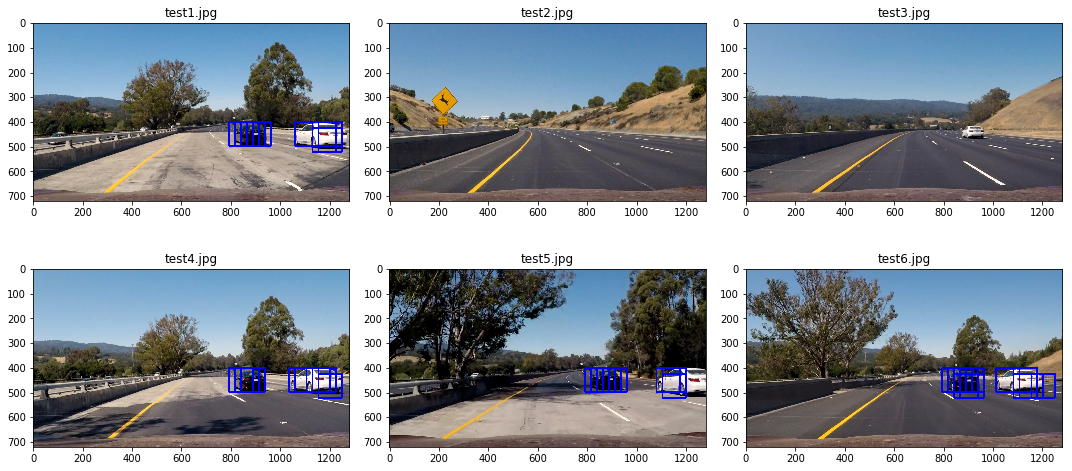

In [38]:
ystart = 400
ystop = 720
scale = 1.5
def test_find_cars(test_image_dir):
    image_name_list = os.listdir(test_image_dir)
    rows = 2
    cols = 3
    fig = plt.figure(figsize=(15, 7))
    idx = 0
    for file_name in image_name_list:
        if file_name.find('jpg') != -1:
            plt.subplot(rows, cols, idx+1)
            idx = idx + 1
            img = mpimg.imread(os.path.join(test_image_dir, file_name))
            windows = find_cars(img, ystart, ystop, scale)
            out_img = draw_boxes(img, windows)
            plt.title(file_name)
            plt.imshow(out_img)
    plt.tight_layout()
    #plt.savefig('test_find_cars.jpg')
test_find_cars('test_images')

In [27]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

In [28]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [29]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [34]:
from scipy.ndimage.measurements import label
scales=[.75, 1., 1.25, 1.5, 2.]
def find_cars_multiscale(img):
    windows_list = []
    for scale in scales:
        windows = find_cars(img, 400, img.shape[0], scale)
        windows_list = windows_list + windows
    
    heatmap_img = np.zeros_like(img[:,:,0])
    #print(windows_list)
    heatmap_img = add_heat(heatmap_img, windows_list)
    heatmap_img = apply_threshold(heatmap_img, 2)
     
    labels = label(heatmap_img)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return heatmap_img, draw_img

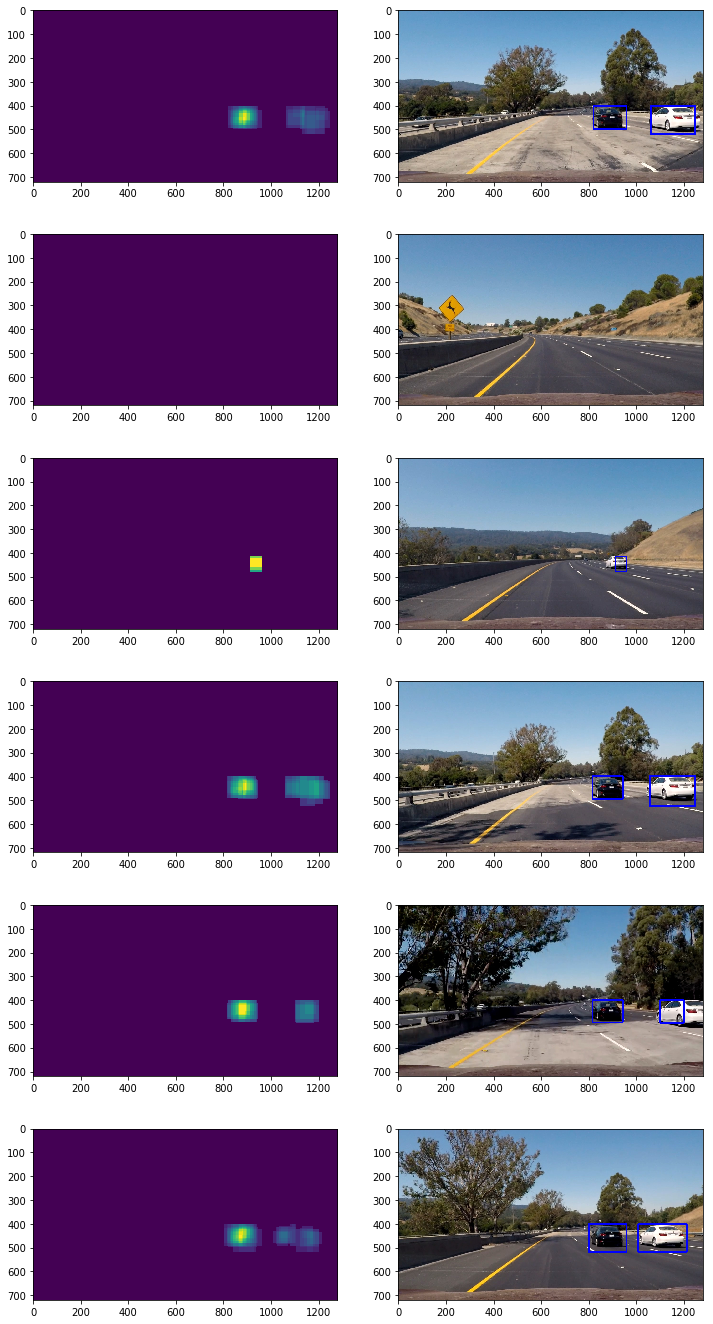

In [39]:
def test_find_cars_multiscale(test_image_dir):
    image_name_list = os.listdir(test_image_dir)
    rows = 6
    cols = 2
    fig = plt.figure(figsize=(12, 24))
    idx = 0
    for file_name in image_name_list:
        if file_name.find('jpg') != -1:
            plt.subplot(rows, cols, idx+1)
            idx = idx + 1
            img = mpimg.imread(os.path.join(test_image_dir, file_name))
            heat_out, out = find_cars_multiscale(img)
            plt.imshow(heat_out)
            plt.subplot(rows, cols, idx +1)
            idx = idx + 1
            plt.imshow(out)
    #plt.savefig('find_cars_heatmap.jpg')
test_find_cars_multiscale('test_images')

In [32]:
heatmap_list = []
max_heatmap_keep = 5

def process_image(img):
    windows_list = []
    
    for scale in scales:
        windows = find_cars(img, 400, img.shape[0], scale)
        windows_list = windows_list + windows
    
    heatmap_img = np.zeros_like(img[:,:,0])
    #print(windows_list)
    heatmap_img = add_heat(heatmap_img, windows_list)
    heatmap_list.append(heatmap_img)
    
    if len(heatmap_list) > max_heatmap_keep:
        heatmap_list.pop(0)
    
    avg_heatmap_img = np.mean(np.array(heatmap_list), axis=0)
    avg_heatmap_img = apply_threshold(heatmap_img, 2)
     
    labels = label(avg_heatmap_img)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [33]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
video_input = 'project_video.mp4'
video_output = 'project_video_output_v4.mp4'
clip1 = (VideoFileClip(video_input))
output_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time output_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output_v4.mp4
[MoviePy] Writing video project_video_output_v4.mp4


100%|█████████▉| 1260/1261 [2:39:34<00:04,  4.59s/it]   


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_v4.mp4 

CPU times: user 1h 23min 7s, sys: 1min 58s, total: 1h 25min 5s
Wall time: 2h 39min 35s
